In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller


In [6]:
# 1. Load the dataset

df = pd.read_csv("../data/financial_data.csv", parse_dates=["Date"])



# 2. Check columns and data
print("Columns:", df.columns)
print("Sample data:")
display(df.head())
print("Befor Cleaning: ")
display(df.isnull() .sum())

# 3. check Date is datetime
if df['Date'].dtype != 'datetime64[ns]':
    df['Date'] = pd.to_datetime(df['Date'])

# 4. Remove duplicates if any exist (keep first occurrence)
df.drop_duplicates(subset=['Ticker', 'Date'], inplace=True)

# 5. Set MultiIndex (Ticker, Date)
df.set_index(['Ticker', 'Date'], inplace=True)

# 6. Sort index to prepare for rolling calculations
df.sort_index(inplace=True)

# 7. Calculate Daily Return per ticker
df['Daily Return'] = df.groupby(level=0)['Adj Close'].pct_change()

# 8. Calculate 21-day rolling volatility per ticker
df['Volatility'] = (
    df.groupby(level=0)['Daily Return']
      .rolling(window=21)
      .std()
      .reset_index(level=0, drop=True)
)

# 9. Drop rows with NaN values (first rows with no returns or volatility)
df.dropna(inplace=True)

# # # 10. Optionally reset index if you want Date as a column again
df.reset_index(inplace=True)

# 11. Save cleaned dataset
df.to_csv("../data/financial_data_clean.csv", index=False)

# 12. Confirm no missing data remains
print("\nMissing values after cleaning:")
print(df.isnull().sum())

print("\n✅ Preprocessing complete. Clean data saved to '../data/financial_data_clean.csv'")


Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Daily Return', 'Volatility', 'Ticker'],
      dtype='object')
Sample data:


,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,Volatility,Ticker
0,2015-07-01,18.073999,18.174667,17.856667,17.943333,17.943333,31518000,NaN,NaN,TSLA
1,2015-07-02,18.680000,18.830000,18.220667,18.667999,18.667999,107458500,0.040386,NaN,TSLA
2,2015-07-06,18.591999,18.779333,18.420000,18.648001,18.648001,61828500,-0.001071,NaN,TSLA
3,2015-07-07,18.333332,18.346666,17.384666,17.858667,17.858667,91576500,-0.042328,NaN,TSLA
4,2015-07-08,17.288000,17.386667,16.954000,16.997334,16.997334,93316500,-0.048231,NaN,TSLA


Befor Cleaning: 


Date             0
Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
Daily Return     3
Volatility      90
Ticker           0
dtype: int64


Missing values after cleaning:
Ticker          0
Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Daily Return    0
Volatility      0
dtype: int64

✅ Preprocessing complete. Clean data saved to '../data/financial_data_clean.csv'


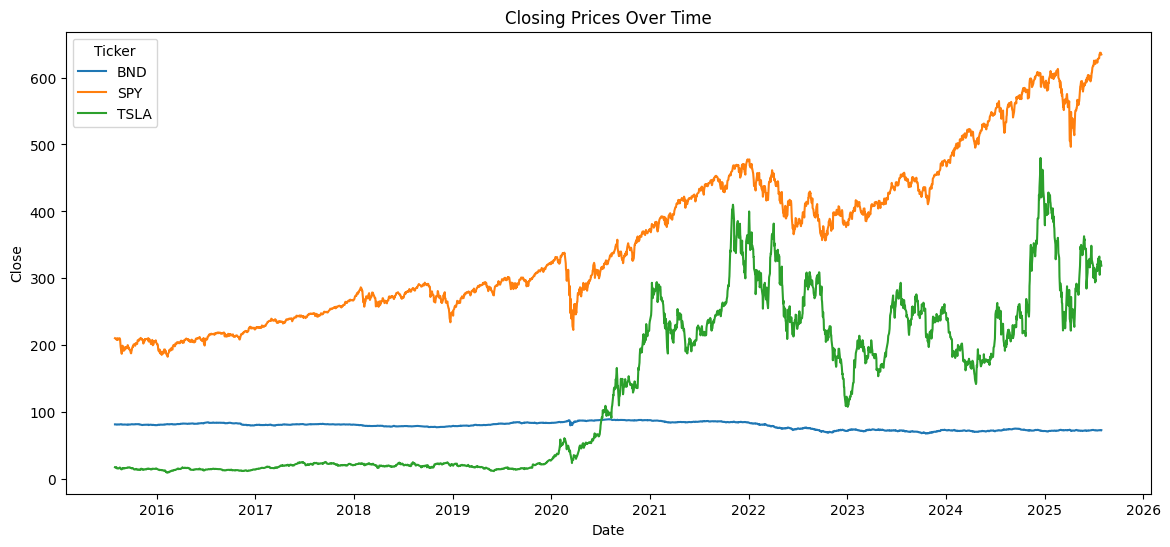

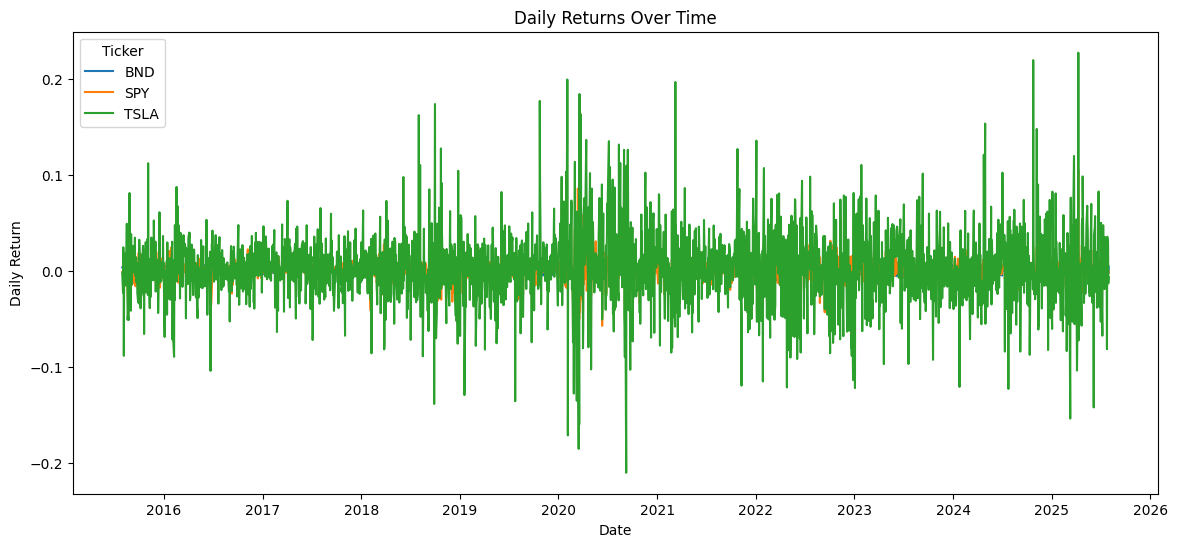

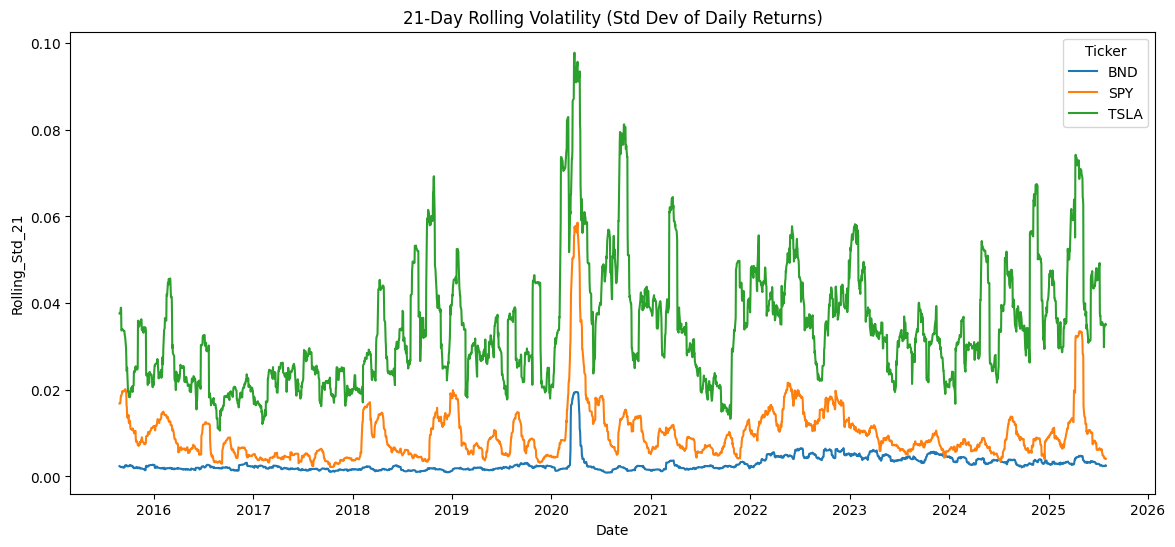

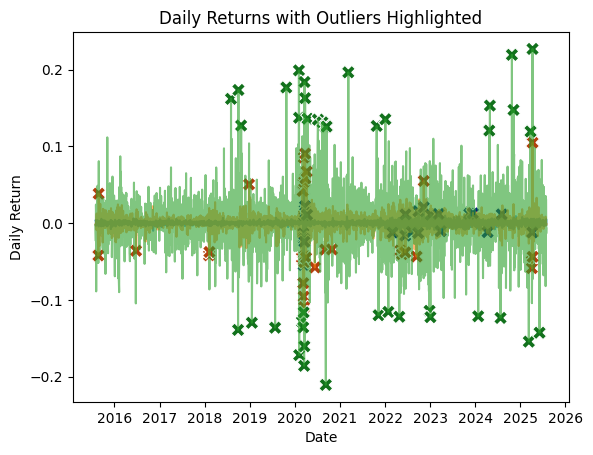

ADF Test for BND Close Prices:
ADF Statistic: -0.8062246129967383
p-value: 0.8172867930362694
Non-stationary

ADF Test for BND Daily Returns:
ADF Statistic: -9.847223597251771
p-value: 4.5853925053930455e-17
Stationary
----------------------------------------
ADF Test for SPY Close Prices:
ADF Statistic: 0.38761386184367147
p-value: 0.9810257891726011
Non-stationary

ADF Test for SPY Daily Returns:
ADF Statistic: -16.18149433678682
p-value: 4.261782079444035e-29
Stationary
----------------------------------------
ADF Test for TSLA Close Prices:
ADF Statistic: -1.4227392536519206
p-value: 0.5713273991590797
Non-stationary

ADF Test for TSLA Daily Returns:
ADF Statistic: -34.506969214387446
p-value: 0.0
Stationary
----------------------------------------
Value at Risk (5% quantile):
Ticker
BND    -0.004925
SPY    -0.017392
TSLA   -0.054663
Name: Daily Return, dtype: float64
Annualized Sharpe Ratio:
Ticker
BND     0.344644
SPY     0.789508
TSLA    0.783333
Name: Daily Return, dtype: float

In [13]:
# visualizing close priceing overtime

plt.figure(figsize=(14,6))
sns.lineplot(data=df, x='Date', y='Close', hue='Ticker')
plt.title('Closing Prices Over Time')
plt.show()

#   Daily Percentage Change (Daily Returns)
plt.figure(figsize=(14,6))
sns.lineplot(data=df, x='Date', y='Daily Return', hue='Ticker')
plt.title('Daily Returns Over Time')
plt.show()

# Rolling Means and Std Dev for Volatility
df['Rolling_Mean_21'] = df.groupby('Ticker')['Daily Return'].transform(lambda x: x.rolling(window=21).mean())
df['Rolling_Std_21'] = df.groupby('Ticker')['Daily Return'].transform(lambda x: x.rolling(window=21).std())

plt.figure(figsize=(14,6))
sns.lineplot(data=df, x='Date', y='Rolling_Std_21', hue='Ticker')
plt.title('21-Day Rolling Volatility (Std Dev of Daily Returns)')
plt.show()

# Outlier Detection (Using Z-score on Daily Returns)


# Calculate z-score and mark outliers
df['Return_Zscore'] = df.groupby('Ticker')['Daily Return'].transform(lambda x: zscore(x, nan_policy='omit'))
df['Outlier'] = df['Return_Zscore'].abs() > 3
outliers = df[df['Outlier']]

# Plot daily returns without legend (to avoid duplicate legends)
sns.lineplot(data=df, x='Date', y='Daily Return', hue='Ticker', alpha=0.6, legend=False)

# Overlay outliers as red X marks
sns.scatterplot(
    data=outliers,
    x='Date',
    y='Daily Return',
    hue='Ticker',
    palette='dark',
    s=100,
    marker='X',
    legend=False
)

plt.title('Daily Returns with Outliers Highlighted')
plt.ylabel('Daily Return')
plt.xlabel('Date')
plt.show()

# Augmented Dickey-Fuller (ADF) Test for Stationarity



for ticker in df['Ticker'].unique():
    print(f'ADF Test for {ticker} Close Prices:')
    close_prices = df[df['Ticker'] == ticker]['Close']
    result = adfuller(close_prices.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')
    print()
    
    print(f'ADF Test for {ticker} Daily Returns:')
    returns = df[df['Ticker'] == ticker]['Daily Return']
    result = adfuller(returns.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')
    print('-'*40)

# Value at Risk (VaR) (Historical method, 5% quantile)
VaR_5 = df.groupby('Ticker')['Daily Return'].quantile(0.05)
print("Value at Risk (5% quantile):")
print(VaR_5)

# Sharpe Ratio (Annualized)


trading_days = 252

sharpe_ratio = df.groupby('Ticker')['Daily Return'].mean() / df.groupby('Ticker')['Daily Return'].std()
sharpe_ratio_annualized = sharpe_ratio * np.sqrt(trading_days)

print("Annualized Sharpe Ratio:")
print(sharpe_ratio_annualized)


